In [1]:
metric_name = 'HttpDispatcher' # Throughput
period_millis = 60 * 1000
frequency_millis = 60 * period_millis
frequency_unit_label = 'hour'
sample_rate = float(frequency_millis) / float(period_millis)

In [2]:
import pandas as pd

data_frame = pd.read_csv('host-data.csv')
data_frame = data_frame.drop('date', 1).drop('max_swapUsedBytes', 1).tail(60)
call_counts = data_frame.values.transpose()[1]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.title(metric_name)
plt.plot(call_counts)
plt.show()

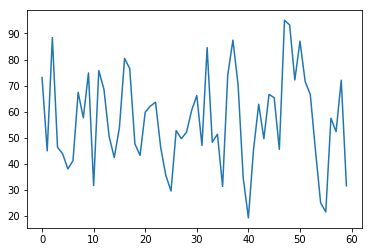

In [4]:
def DFT(x):
    # DFT is a measure of the amount of frequency ω in the function x(t)
    # 
    # The product of two complex sinusoids is also a complex sinusoid
    # whose frequency is the sum of the original frequencies.
    # So when ω is positive, e^(-iωt) causes all the frequencies of x(t) to be reduced by amount ω.
    # Whatever part of x(t) that was at frequency ω is changed to frequency zero,
    # which is just a constant whose amplitude level is a measure of the strength of the original ω content.
    N = x.size
    xn = np.arange(N) # [0, 1, ..., N - 1]
    return np.array([ (x * np.exp(-1j * 2 * np.pi * k / N * xn)).sum() for k in xn ])

def IDFT(X):
    N = X.size
    xn = np.arange(N) # [0, 1, ..., N - 1]
    return np.array([ 1.0 / N * (X * np.exp(1j * 2 * np.pi * n / N * xn)).sum() for n in xn ])

# unoptimized, direct impl of DFT
X = DFT(call_counts)
# unoptimized, direct impl of inverse DFT
idft = IDFT(X)
# take the real components
idft = idft.real

# plot the real components of the IDFT
plt.plot(idft)
plt.axis('tight')
plt.show()

In [5]:
# verify that the error is effectively 0 (we've exactly reproduced original time-domain signal from its frequency components!)
def rmse(estimated, actual):
    return np.sqrt(((estimated - actual) ** 2).sum() / actual.size)

def formatted_rmse(estimated, actual):
    return 'RMSE: {0:.3f}'.format(rmse(estimated, actual))

print(formatted_rmse(idft, call_counts))

RMSE: 0.000


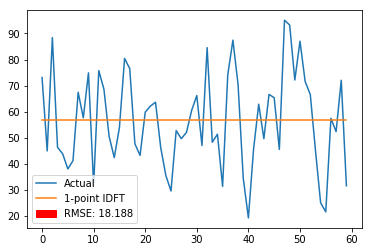

In [6]:
from matplotlib import animation, rc, patches
from IPython.display import HTML
import time

def n_point_idft(X, n):
    n_point_X = np.zeros(X.size, dtype=np.complex_)
    n_point_X[:n] = X[:n]
    return np.fft.ifft(n_point_X).real

fig = plt.figure()
actual_line, = plt.plot(call_counts) # plot original call counts
n_point_X_line, = plt.plot(idft)
rmse_patch = patches.Patch(color='red')
plt.axis('tight')

def animate(i):
    idft = n_point_idft(X, i + 1)
    n_point_X_line.set_ydata(idft)
    plt.legend(handles=[actual_line, n_point_X_line, rmse_patch], \
               labels=['Actual', '{0:d}-point IDFT'.format(i + 1), formatted_rmse(idft, call_counts)], loc=3)

anim = animation.FuncAnimation(fig, animate, frames=X.size, repeat=False, interval=100)
HTML(anim.to_html5_video())

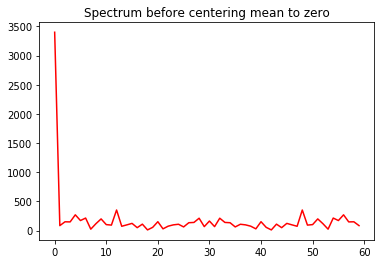

In [7]:
X = np.abs(DFT(call_counts))
plt.close()
plt.title('Spectrum before centering mean to zero')
plt.plot(X, color='red')
plt.axis('tight')
plt.show()

![](http://i.imgur.com/o5WCAYf.jpg)

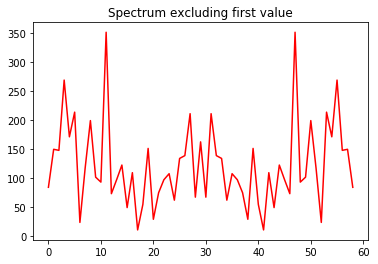

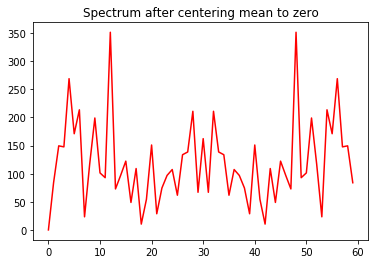

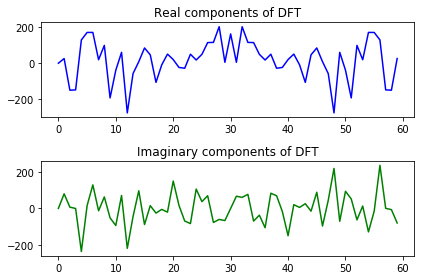

In [8]:
plt.title('Spectrum excluding first value')
plt.plot(X[1:], color='red')
plt.axis('tight')
plt.show()

call_counts_centered = call_counts.copy() - call_counts.mean()
X_centered = np.abs(DFT(call_counts_centered))
plt.title('Spectrum after centering mean to zero')
plt.plot(X_centered, color='red')
plt.axis('tight')
plt.show()

X_complex = DFT(call_counts_centered)
real_plot = plt.subplot(211)
real_plot.set_title('Real components of DFT')
real_plot.plot(X_complex.real, color='blue')
real_plot.axis('tight')

imaginary_plot = plt.subplot(212)
imaginary_plot.set_title('Imaginary components of DFT')
imaginary_plot.plot(X_complex.imag, color='green')
imaginary_plot.axis('tight')
plt.tight_layout()
plt.show()


### Negative frequencies

![](http://www.med.harvard.edu/jpnm/physics/didactics/improc/intro/eulers.gif)

![Complex sinusoids](http://i.stack.imgur.com/eCpbp.gif)

In the case of real signals, there are always two equal-amplitude complex exponentials, rotating in opposite directions, so that their real parts combine and imaginary parts cancel out, leaving only a real sinusoid as the result. This is why the spectrum of a sine wave always has 2 spikes, one positive frequency and one negative. Depending on the phase of the two spirals, they could cancel out leaving a purely real sine wave or a real cosine wave or a purely imaginary sine wave, etc.

![](http://www.thefouriertransform.com/series/cosineIdentities.jpg)

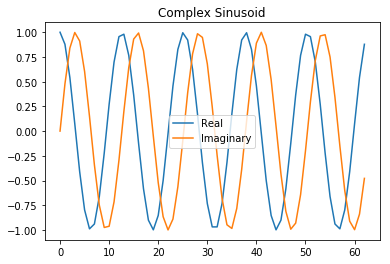

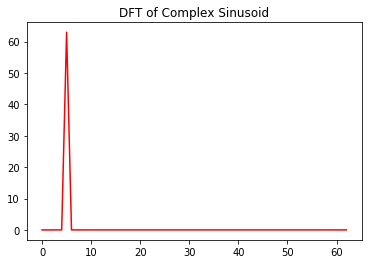

In [9]:
# demonstrate that the Fourier transform of a complex-valued sinusoid has a single spike...
import numpy as np
import matplotlib.pyplot as plt

plt.title('Complex Sinusoid')
complex_sinusoid = np.exp(1j * np.linspace(0, np.pi * 10, 64))[:-1]
real_line, = plt.plot(complex_sinusoid.real, label='Real')
imag_line, = plt.plot(complex_sinusoid.imag, label='Imaginary')
plt.legend(handles=[real_line, imag_line])
plt.axis('tight')
plt.show()

plt.title('DFT of Complex Sinusoid')
plt.plot(np.abs(np.fft.fft(complex_sinusoid)), color='red')
plt.axis('tight')
plt.show()


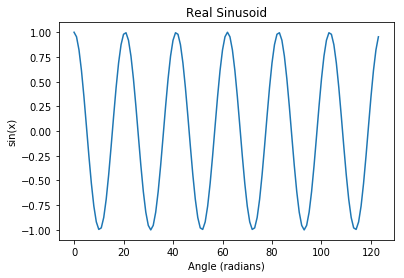

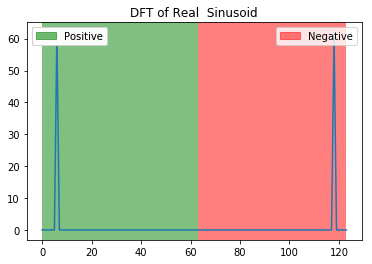

In [10]:
# ... and that a real-valued sinusoid has two spikes

import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt

N = 124
x = np.linspace(0, 12 * np.pi, N + 1)[:-1]
real_sinusoid = np.cos(x)
plt.title('Real Sinusoid')
plt.xlabel('Angle (radians)')
plt.ylabel('sin(x)')
plt.plot(real_sinusoid)
plt.axis('tight')
plt.show()

X = np.abs(np.fft.fft(real_sinusoid))
plt.title('DFT of Real  Sinusoid')
plt.axvspan(0, N // 2 + 1, facecolor='green', alpha=0.5)
plt.axvspan(N // 2 + 1, N - 1, facecolor='red', alpha=0.5)
plt.gca().add_artist(plt.legend(handles=[patches.Patch(color='red', alpha=0.5)], loc=1, labels=['Negative']))
plt.gca().add_artist(plt.legend(handles=[patches.Patch(color='green', alpha=0.5)], loc=2, labels=['Positive']))
plt.plot(X)
plt.axis('tight')
plt.show()

# second half of spectrum values are negative frequencies

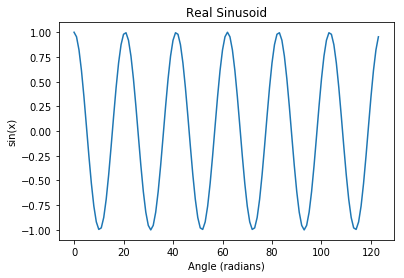

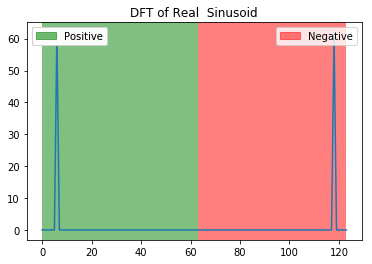

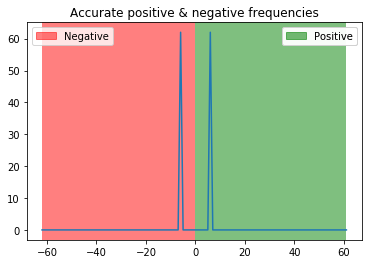

In [11]:
# ... and that a real-valued sinusoid has two spikes

import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt

N = 124
x = np.linspace(0, 12 * np.pi, N + 1)[:-1]
real_sinusoid = np.cos(x)
plt.title('Real Sinusoid')
plt.xlabel('Angle (radians)')
plt.ylabel('sin(x)')
plt.plot(real_sinusoid)
plt.axis('tight')
plt.show()

X = np.abs(np.fft.fft(real_sinusoid))
plt.title('DFT of Real  Sinusoid')
plt.axvspan(0, N // 2 + 1, facecolor='green', alpha=0.5)
plt.axvspan(N // 2 + 1, N - 1, facecolor='red', alpha=0.5)
plt.gca().add_artist(plt.legend(handles=[patches.Patch(color='red', alpha=0.5)], loc=1, labels=['Negative']))
plt.gca().add_artist(plt.legend(handles=[patches.Patch(color='green', alpha=0.5)], loc=2, labels=['Positive']))
plt.plot(X)
plt.axis('tight')
plt.show()

# second half of spectrum values are negative frequencies
X_flipped = np.zeros(X.size)
X_flipped[:N // 2] = X[N // 2:]
X_flipped[N // 2:] = X[:N // 2]

plt.title('Accurate positive & negative frequencies')
plt.axvspan(-N // 2, 0, facecolor='red', alpha=0.5)
plt.axvspan(0, N // 2 - 1, facecolor='green', alpha=0.5)
plt.gca().add_artist(plt.legend(handles=[patches.Patch(color='red', alpha=0.5)], loc=2, labels=['Negative']))
plt.gca().add_artist(plt.legend(handles=[patches.Patch(color='green', alpha=0.5)], loc=1, labels=['Positive']))
plt.plot(np.arange(-N // 2, N // 2), np.abs(X_flipped))
plt.axis('tight')
plt.show()

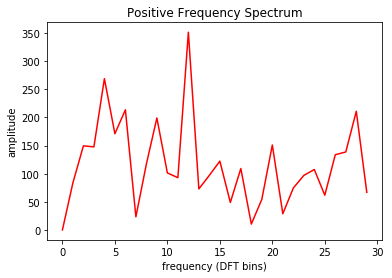

In [12]:
# take only positive frequency components
def get_positive_frequencies(X):
    return X[:X.size // 2]

X_centered_positive = get_positive_frequencies(X_centered)
plt.title('Positive Frequency Spectrum')
plt.xlabel('frequency (DFT bins)')
plt.ylabel('amplitude')
plt.plot(X_centered_positive, color='red')
plt.axis('tight')
plt.show()

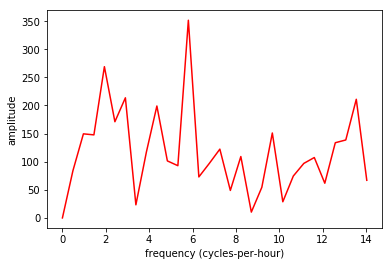

In [13]:
def get_magnitude_spectrum(x):
    return np.abs(get_positive_frequencies(np.fft.fft(x)))

# So now we have the frequency in... some weird units ("frequency bin index")
# Let's convert these bin indices to real-world time values
def chart_spectrum():
    plt.xlabel('frequency (cycles-per-' + frequency_unit_label + ')')
    plt.ylabel('amplitude')

chart_spectrum()
plt.plot(sample_rate * np.arange(X_centered_positive.size) / float(X.size), X_centered_positive, color='red')
plt.axis('tight')
plt.show()

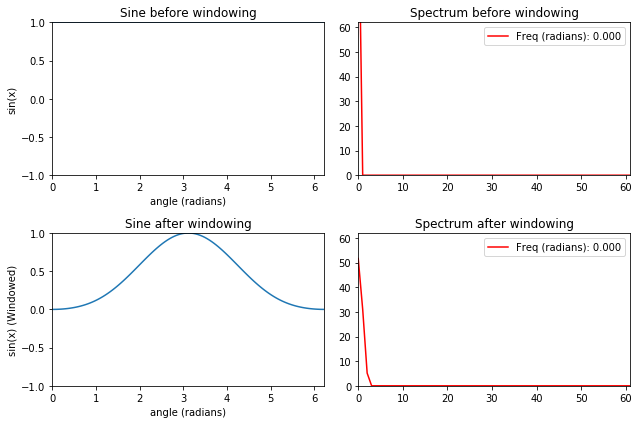

In [14]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

# Sending raw data into the DFT behaves like a rectangular window and thus has high sidelobe amplitude,
# introducing distortions into the spectrum.

N = 124

fig = plt.figure(figsize=(9, 6))

plt.title('Real Sinusoid')
signal_plot = plt.subplot(221)
signal_plot.set_xlabel('angle (radians)')
signal_plot.set_ylabel('sin(x)')

X_plot = plt.subplot(222)

signal_plot_windowed = plt.subplot(223)
signal_plot_windowed.set_xlabel('angle (radians)')
signal_plot_windowed.set_ylabel('sin(x) (Windowed)')
X_plot_windowed = plt.subplot(224)

signal_plot.set_title('Sine before windowing')
X_plot.set_title('Spectrum before windowing')
signal_plot_windowed.set_title('Sine after windowing')
X_plot_windowed.set_title('Spectrum after windowing')

x_max = 2 * np.pi * (1.0 - 1.0 / N)
x = np.linspace(0, x_max, N) # multiple of pi will be exactly periodic over window length
signal_line, = signal_plot.plot(x, np.zeros(N), label='Angle (radians)')
X_line, = X_plot.plot(np.zeros(int(N / 2)), color='red')
signal_windowed_line, = signal_plot_windowed.plot(x, np.zeros(N), label='Angle (radians)')
X_line_windowed, = X_plot_windowed.plot(np.zeros(int(N / 2)), color='red')

window = np.blackman(N)
def animate_varying_frequencies(i):
    freq = i * 0.2
    y = np.cos(freq * x)
    X = get_magnitude_spectrum(y)
    signal_line.set_ydata(y)
    X_line.set_ydata(X)
    X_plot.legend(handles=[X_line], labels=['Freq (radians): {0:.3f}'.format(freq)])

    y_windowed = y * window
    signal_windowed_line.set_ydata(y_windowed)
    X_windowed = get_magnitude_spectrum(y_windowed)
    X_line_windowed.set_ydata(X_windowed)
    X_plot_windowed.legend(handles=[X_line_windowed], labels=['Freq (radians): {0:.3f}'.format(freq)])

signal_plot.axis([0, x_max, -1, 1])
X_plot.axis([0, N / 2 - 1, 0, N / 2])
signal_plot_windowed.axis([0, x_max, -1, 1])
X_plot_windowed.axis([0, N / 2 - 1, 0, N / 2])
plt.tight_layout()

anim = animation.FuncAnimation(fig, animate_varying_frequencies, frames=100, repeat=False, interval=128)
HTML(anim.to_html5_video())

## Windowing
![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Window_function_and_frequency_response_-_Rectangular.svg/960px-Window_function_and_frequency_response_-_Rectangular.svg.png)
![](https://upload.wikimedia.org/wikipedia/commons/f/f6/Spectral_leakage_from_a_sinusoid_and_rectangular_window.png)


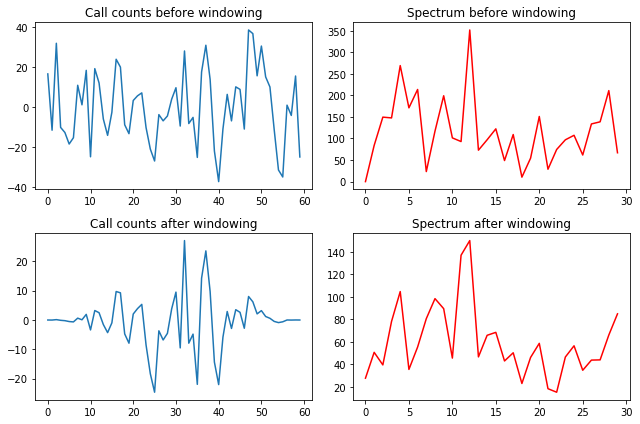

In [15]:
# call_count series & spectrum before and after windowing

plt.close()
plt.figure(figsize=(9, 6))
X = get_magnitude_spectrum(call_counts_centered)
call_counts_centered_windowed = call_counts_centered * np.blackman(call_counts_centered.size)

signal_plot = plt.subplot(221)
X_plot = plt.subplot(222)
signal_plot_windowed = plt.subplot(223)
X_plot_windowed = plt.subplot(224)

signal_plot.set_title('Call counts before windowing')
X_plot.set_title('Spectrum before windowing')
signal_plot_windowed.set_title('Call counts after windowing')
X_plot_windowed.set_title('Spectrum after windowing')

signal_line, = signal_plot.plot(call_counts_centered)
X_plot.plot(X, color='red')
signal_line_windowed, = signal_plot_windowed.plot(call_counts_centered_windowed)
X_windowed = get_magnitude_spectrum(call_counts_centered_windowed)
X_plot_windowed.plot(X_windowed, color='red')

signal_plot.axis('tight')
signal_plot_windowed.axis('tight')
X_plot.axis('tight')
X_plot_windowed.axis('tight')

plt.tight_layout()
plt.show()

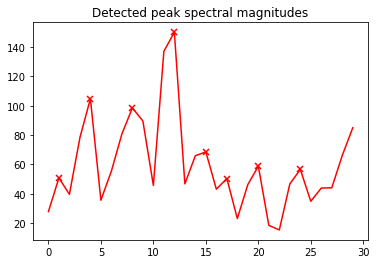

In [16]:
# Find the peaks!

def detect_peaks(mX, t):
    thresh = np.where(mX[1:-1] > t, mX[1:-1], 0);           # locations above threshold
    next_minor = np.where(mX[1:-1] > mX[2:], mX[1:-1], 0)   # locations higher than the next one
    prev_minor = np.where(mX[1:-1] > mX[:-2], mX[1:-1], 0)  # locations higher than the previous one
    peak_locations = thresh * next_minor * prev_minor                 # locations fulfilling the three criteria
    peak_locations = peak_locations.nonzero()[0] + 1                            # add 1 to compensate for previous steps
    return peak_locations

peak_locations = detect_peaks(X_windowed, 0)
plt.plot(X_windowed, color='red')
plt.title('Detected peak spectral magnitudes')
plt.plot(sample_rate * peak_locations / (X_windowed.size * 2), X_windowed[peak_locations], marker='x', color='red', alpha=1, linestyle='', markeredgewidth=1.5)
plt.axis('tight')
plt.show()

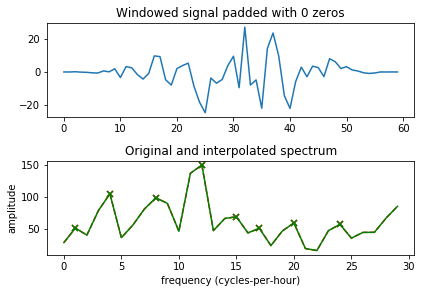

In [17]:
# zero-padding the time domain corresponds to interpolation in the frequency domain
fig = plt.figure()
N = call_counts.size
# plot original (uninterpolated) spectrum
call_counts_centered_windowed = call_counts_centered * np.blackman(N)
X_centered_positive_windowed = get_magnitude_spectrum(call_counts_centered_windowed)

signal_plot = plt.subplot(211)
X_plot = plt.subplot(212)

X_plot.set_title('Original and interpolated spectrum')
signal_line, = signal_plot.plot(call_counts_centered_windowed)
chart_spectrum()
X_plot.plot(sample_rate * np.arange(X_centered_positive_windowed.size) / float(N), X_centered_positive_windowed, color='red', linestyle='dashed')
X_plot.plot(sample_rate * peak_locations / float(N), X_centered_positive_windowed[peak_locations], marker='x', color='red', alpha=1, linestyle='', markeredgewidth=1.5)

X_interpolated = X_centered_positive_windowed.copy()
zero_padded_peak_locations = peak_locations.copy() # start state
zero_padded_peak_magnitudes = X_interpolated[zero_padded_peak_locations]

X_interpolated_line, = X_plot.plot(sample_rate * np.arange(X_interpolated.size) / float(N), X_interpolated, color='green')
peaks_line, = X_plot.plot(sample_rate * zero_padded_peak_locations / float(X_interpolated.size * 2), zero_padded_peak_magnitudes, marker='x', color='green', alpha=1, linestyle='', markeredgewidth=1.5)

X_plot.axis('tight')

plt.tight_layout()

def animate_interpolation(i):
    num_zeros_to_pad_with = i * 4
    call_counts_centered_windowed_padded = np.zeros(N + num_zeros_to_pad_with)
    call_counts_centered_windowed_padded[:call_counts_centered_windowed.size] = call_counts_centered_windowed
    signal_plot.cla()
    signal_plot.set_title('Windowed signal padded with {0:d} zeros'.format(num_zeros_to_pad_with))
    signal_plot.plot(call_counts_centered_windowed_padded)
    signal_plot.axis('tight')
    chart_spectrum()
    X_interpolated = get_magnitude_spectrum(call_counts_centered_windowed_padded)
    X_interpolated_line.set_data(sample_rate * np.arange(X_interpolated.size) / float(X_interpolated.size * 2), X_interpolated)

    zero_padded_peak_locations = detect_peaks(X_interpolated, 0)
    zero_padded_peak_magnitudes = X_interpolated[zero_padded_peak_locations]
    peaks_line.set_data(sample_rate * zero_padded_peak_locations / float(X_interpolated.size * 2), zero_padded_peak_magnitudes)
    plt.axis('tight')

anim = animation.FuncAnimation(fig, animate_interpolation, frames=64, repeat=False, interval=100)
HTML(anim.to_html5_video())

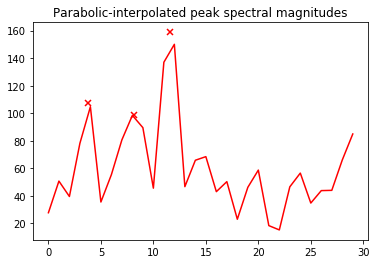

In [18]:
# Use parabolic interpolation
def interpolate_parabolic(mX, peak_locations):
    val = mX[peak_locations]                                               # magnitude of peak bin
    lval = mX[peak_locations - 1]                                          # magnitude of bin at left
    rval = mX[peak_locations + 1]                                          # magnitude of bin at right
    iploc = peak_locations + 0.5 * (lval - rval) / (lval - 2 * val + rval) # center of parabola
    ipmag = val - 0.25 * (lval - rval) * (iploc - peak_locations)          # magnitude of peaks
    return iploc, ipmag

peak_locations = detect_peaks(X_windowed, X_windowed.max() / 2)
interpolated_peak_locations, peak_magnitudes = interpolate_parabolic(X_windowed, peak_locations)
plt.plot(X_windowed, color='red')
plt.title('Parabolic-interpolated peak spectral magnitudes')
plt.plot(sample_rate * interpolated_peak_locations / float(X_windowed.size * 2), peak_magnitudes, marker='x', color='red', alpha=1, linestyle='', markeredgewidth=1.5)
plt.axis('tight')
plt.show()

### Checkpoint - this is enough for season detection!

But we need more if we want to do time-series reproduction without the full DFT

## Phase
![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Complex_number_illustration_modarg.svg/440px-Complex_number_illustration_modarg.svg.png)


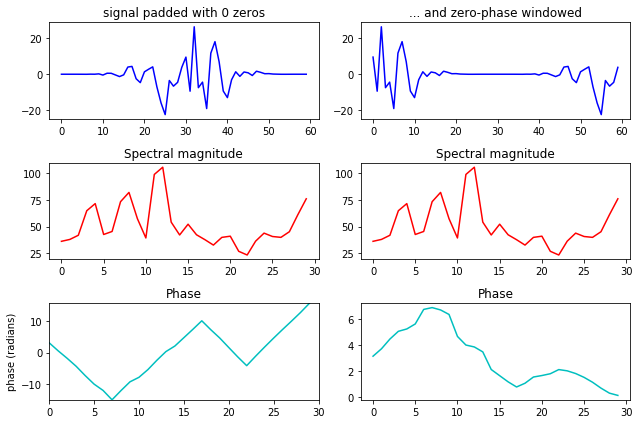

In [19]:
M = call_counts_centered_windowed.size
N = call_counts_centered_windowed.size
xw = call_counts_centered_windowed * np.blackman(M)

X = get_positive_frequencies(np.fft.fft(xw))
pX = np.unwrap(np.angle(X)) # unwrapped phase spectrum of positive frequencies

fig = plt.figure(figsize=(9, 6))

# windowing w/o zero-phase
signal_plot = plt.subplot(321)
signal_plot.set_title('Windowed signal')
signal_plot.plot(xw, color='blue')
signal_plot.axis('tight')

spectrum_plot = plt.subplot(323)
spectrum_plot.set_title('Spectral magnitude')
spectrum_line, = spectrum_plot.plot(sample_rate * np.arange(X.size) / float(N), np.abs(X), color='red')
spectrum_plot.axis('tight')

phase_plot = plt.subplot(325)
phase_plot.set_title('Phase')
phase_line, = phase_plot.plot(sample_rate * np.arange(X.size) / float(N), pX, 'c', lw=1.5)
phase_plot.axis('tight')
phase_plot.set_ylabel('phase (radians)')

# windowing w/ zero-phase
zero_phase_windowed_xw = np.zeros(xw.size)
zero_phase_windowed_xw[:M // 2] = xw[M // 2:]
zero_phase_windowed_xw[-(M // 2):] = xw[:(M // 2)]
zero_phase_windowed_X = get_positive_frequencies(np.fft.fft(zero_phase_windowed_xw))
zero_phase_windowed_pX = np.unwrap(np.angle(zero_phase_windowed_X)) # unwrapped phase spectrum of positive frequencies

zero_phase_windowed_signal_plot = plt.subplot(322)
zero_phase_windowed_signal_plot.set_title('Zero-phase-windowed signal')
zero_phase_windowed_signal_plot.plot(zero_phase_windowed_xw, color='blue')
zero_phase_windowed_signal_plot.axis('tight')

zero_phase_windowed_spectrum_plot = plt.subplot(324)
zero_phase_windowed_spectrum_plot.set_title('Spectral magnitude')
zero_phase_windowed_spectrum_line, = zero_phase_windowed_spectrum_plot.plot(sample_rate * np.arange(X.size) / float(N), np.abs(zero_phase_windowed_X), color='red')
zero_phase_windowed_spectrum_plot.axis('tight')

zero_phase_windowed_phase_plot = plt.subplot(326)
zero_phase_windowed_phase_plot.set_title('Phase')
zero_phase_windowed_phase_line, = zero_phase_windowed_phase_plot.plot(sample_rate * np.arange(X.size) / float(N), zero_phase_windowed_pX, 'c', lw=1.5)
zero_phase_windowed_phase_plot.axis('tight')

plt.tight_layout()

def animate_zero_phased_windowing(i):
    num_zeros_to_pad_with = i * 8
    N = xw.size + num_zeros_to_pad_with
    xw_zero_padded = np.zeros(N)
    xw_zero_padded[:xw.size] = xw

    # windowing w/o zero-phase
    X = get_positive_frequencies(np.fft.fft(xw_zero_padded))
    pX = np.unwrap(np.angle(X))

    signal_plot.cla()
    signal_plot.set_title('signal padded with {0:d} zeros'.format(num_zeros_to_pad_with))
    signal_plot.plot(xw_zero_padded, color='blue')
    signal_plot.axis('tight')

    spectrum_line.set_data(sample_rate * np.arange(X.size) / float(N), np.abs(X))
    spectrum_plot.axis('tight')

    phase_line.set_data(sample_rate * np.arange(X.size) / float(N), pX)
    phase_plot.axis([0, xw.size / 2, min(pX), max(pX)])

    # windowing w/ zero-phase
    zero_phase_windowed_xw = np.zeros(N)
    zero_phase_windowed_xw[:M // 2] = xw[M // 2:]
    zero_phase_windowed_xw[-(M // 2):] = xw[:(M // 2)]
    zero_phase_windowed_X = get_positive_frequencies(np.fft.fft(zero_phase_windowed_xw))
    zero_phase_windowed_pX = np.unwrap(np.angle(zero_phase_windowed_X))

    zero_phase_windowed_signal_plot.cla()
    zero_phase_windowed_signal_plot.set_title('... and zero-phase windowed'.format(num_zeros_to_pad_with))
    zero_phase_windowed_signal_plot.plot(zero_phase_windowed_xw, color='blue')
    zero_phase_windowed_signal_plot.axis('tight')

    zero_phase_windowed_spectrum_line.set_data(sample_rate * np.arange(zero_phase_windowed_X.size) / float(N), np.abs(zero_phase_windowed_X))
    zero_phase_windowed_spectrum_plot.axis('tight')

    zero_phase_windowed_phase_line.set_data(sample_rate * np.arange(zero_phase_windowed_X.size) / float(N), zero_phase_windowed_pX)
    zero_phase_windowed_phase_plot.axis('tight')

anim = animation.FuncAnimation(fig, animate_zero_phased_windowing, frames=24, repeat=False, interval=100)
HTML(anim.to_html5_video())